In [1]:
# 데이터 구성 : Series, DataFrame
import pandas as pd

# 행렬 연산
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family = "Malgun Gothic")
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline
import seaborn as sns

# 날짜 데이터 생성
from datetime import datetime

# 선형회귀분석 (절편(intercept) 추가)
import statsmodels.api as sm

# 자기상관 함수, 부분 자기상관 함수
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

In [2]:
# 파일명, 변수, 값 등에 한글 포함시 engine = "python" 지정, parse_dates : 날짜 변수 식별
df_raw = pd.read_csv("data/환율.csv", engine = "python", parse_dates = ["APPL_DATE"])
df_raw

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294
...,...,...,...,...
268,JPY,2016-03-30,1026.90,0.8906
269,USD,2016-03-30,1153.00,1.0000
270,CNY,2016-03-31,176.96,0.1547
271,JPY,2016-03-31,1017.57,0.8895


## 변동 추세 확인 - 시간에 따른 환율 추세 그래프 생성

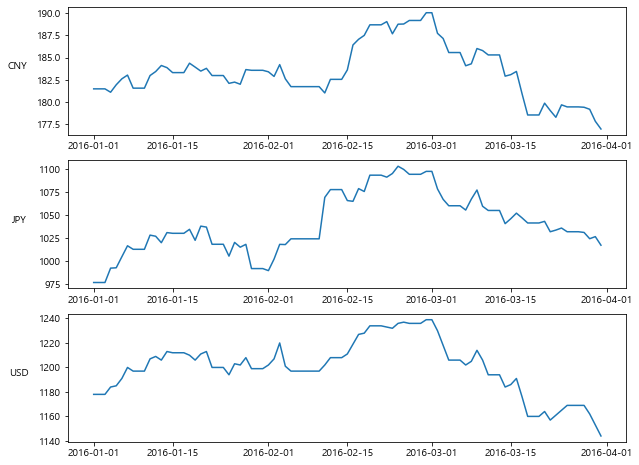

In [13]:
# 중국 위엔화와 엔화/달러 단위 크기가 다르기 때문에 각각 그래프를 생성 -> 3행 1열, 크기 : (10,8)
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))

# zip 함수를 사용하면 zip 함수 안의 리스트들을 하나씩 출력
# 1번 loop : ax1, 311, "CNY"
# 2번 loop : ax2, 312, "JPY"
# 3번 loop : ax3, 313, "USD"
for (ax, idx, currency) in zip([ax1, ax2, ax3], [311, 312, 313], ["CNY", "JPY", "USD"]):
    # plot 추가, 311 -> 3행 1열의 1번 그래프
    ax.plot("APPL_DATE", "STD_RATE", data = df_raw[df_raw["CURRENCY"] == currency])
    # y축에 통화 표시 rotation : label 가로로 생성, labelpad : label과 그래프 사이의 거리
    ax.set_ylabel(currency, rotation = 0, labelpad = 20)

### ㄴ 초반 구간과 후반 구간의 평균이 다르고 변동이 달라 정상성이 만족되지 않음 -> 차분 필요 확인

## 시계열 분석
### : 데이터 분할 - 통화별 데이터 분할

In [19]:
# CNY 데이터 선택 후 APPL_DATE를 index로 설정
df_CNY = df_raw[df_raw["CURRENCY"] == "CNY"].set_index("APPL_DATE")
df_CNY

,CURRENCY,STD_RATE,USD_CONV_DATE
APPL_DATE,,,
2016-01-01,CNY,181.48,0.1541
2016-01-02,CNY,181.48,0.1541
2016-01-03,CNY,181.48,0.1541
2016-01-04,CNY,181.10,0.1540
2016-01-05,CNY,181.94,0.1530
...,...,...,...
2016-03-27,CNY,179.45,0.1535
2016-03-28,CNY,179.41,0.1535
2016-03-29,CNY,179.18,0.1537


In [20]:
# drop method를 이용해 통화(CURRENCY)와 미달러 환산율(USD_CONV_DATE) 변수 제외
df_CNY.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)
df_CNY

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94
...,...
2016-03-27,179.45
2016-03-28,179.41
2016-03-29,179.18


In [21]:
# JPY 데이터 생성
df_JPY = df_raw[df_raw["CURRENCY"] == "JPY"].set_index("APPL_DATE")
df_JPY.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)

# USD 데이터 생성 : 실습용 데이터
df_USD = df_raw[df_raw["CURRENCY"] == "USD"].set_index("APPL_DATE")
df_USD.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)

### : 데이터 분할 - train/test 데이터 분할

In [22]:
# Train & Test 데이터 분할 : 비율 기준 mask 지정
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx) / len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [27]:
np.arange(len_idx)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

In [26]:
np.arange(len_idx) / len_idx

array([0.        , 0.01098901, 0.02197802, 0.03296703, 0.04395604,
       0.05494505, 0.06593407, 0.07692308, 0.08791209, 0.0989011 ,
       0.10989011, 0.12087912, 0.13186813, 0.14285714, 0.15384615,
       0.16483516, 0.17582418, 0.18681319, 0.1978022 , 0.20879121,
       0.21978022, 0.23076923, 0.24175824, 0.25274725, 0.26373626,
       0.27472527, 0.28571429, 0.2967033 , 0.30769231, 0.31868132,
       0.32967033, 0.34065934, 0.35164835, 0.36263736, 0.37362637,
       0.38461538, 0.3956044 , 0.40659341, 0.41758242, 0.42857143,
       0.43956044, 0.45054945, 0.46153846, 0.47252747, 0.48351648,
       0.49450549, 0.50549451, 0.51648352, 0.52747253, 0.53846154,
       0.54945055, 0.56043956, 0.57142857, 0.58241758, 0.59340659,
       0.6043956 , 0.61538462, 0.62637363, 0.63736264, 0.64835165,
       0.65934066, 0.67032967, 0.68131868, 0.69230769, 0.7032967 ,
       0.71428571, 0.72527473, 0.73626374, 0.74725275, 0.75824176,
       0.76923077, 0.78021978, 0.79120879, 0.8021978 , 0.81318

In [28]:
# mask를 이용한 데이터 분할
df_CNY_train = df_CNY[mask]
df_CNY_train

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94
...,...
2016-03-18,178.54
2016-03-19,178.54
2016-03-20,178.54


In [30]:
df_CNY_test = df_CNY[~mask]
df_CNY_test

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45
2016-03-28,179.41
2016-03-29,179.18
2016-03-30,177.83
2016-03-31,176.96


In [ ]:
print("shape of train data: {}".format(df_CNY_train.shape))
print("shape of test data: {}".format(df_CNY_test.shape))